Copyright 2015-2025 Universidad Complutense de Madrid (UCM)

This file contains code adapted from Numina https://github.com/guaix-ucm/numina.

It was developed by N. Cardiel for students of the Astrophysics Master (UCM).

This is an adapted version for lectures at ULS (Chile).

* License:
SPDX-License-Identifier: GPL-3.0+

* Modified by:
C. Cabello (UCM; Spain), 
L. Costantin (CAB; Spain)

## Flux calibration

### Imports

In [2]:
'''
:Settings:
conda activate uls_2025

:History:
23 Mar 25:  version 1.0
'''

import numpy as np
import teareduce as tea
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import astropy.constants as constants

from pathlib import Path
from tqdm.notebook import tqdm
from astropy.table import QTable
from astropy.io import fits, ascii
from scipy.interpolate import interp1d
from numsplines import AdaptiveLSQUnivariateSpline

tea.avoid_astropy_warnings(True)

__version__ = "1.0"
__author__  = "Cristina Cabello (UCM, Spain) and Luca Costantin (CAB, Spain)"


### Read files

In [3]:
galaxy_ID        = 'NGC2366'
specphot_star_ID = 'HR3454'

## MODIFY THE FOLLOWING

abs_path = f'/home/diegosuzaku/NGC2366Workshop'

dir_data = Path(f'{abs_path}/data/spectroscopy')
dir_calibration = Path(f'{abs_path}/calibration/spectroscopy')


#### Observed spectrum of the standard star


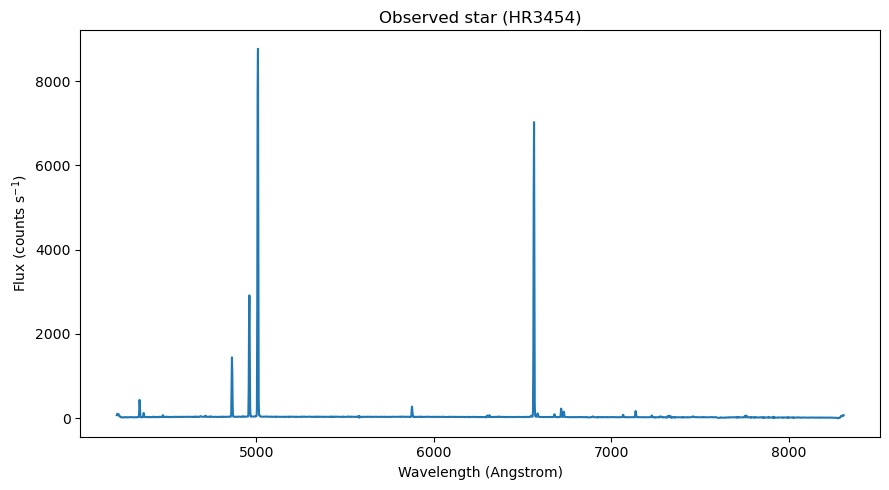

In [6]:
table_obs = np.genfromtxt(dir_calibration / f'{galaxy_ID}_1d_spec_atmcorr.ecsv')
wave_obs = table_obs[:, 0]
flux_obs = table_obs[:, 1]

header  = fits.getheader(dir_calibration / 't_science_star.fits')
exptime = header['EXPTIME']

flux_obs = flux_obs / exptime

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(wave_obs, flux_obs)
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel(r'Flux (counts s$^{-1}$)')
ax.set_title(f'Observed star ({specphot_star_ID})')
plt.tight_layout()

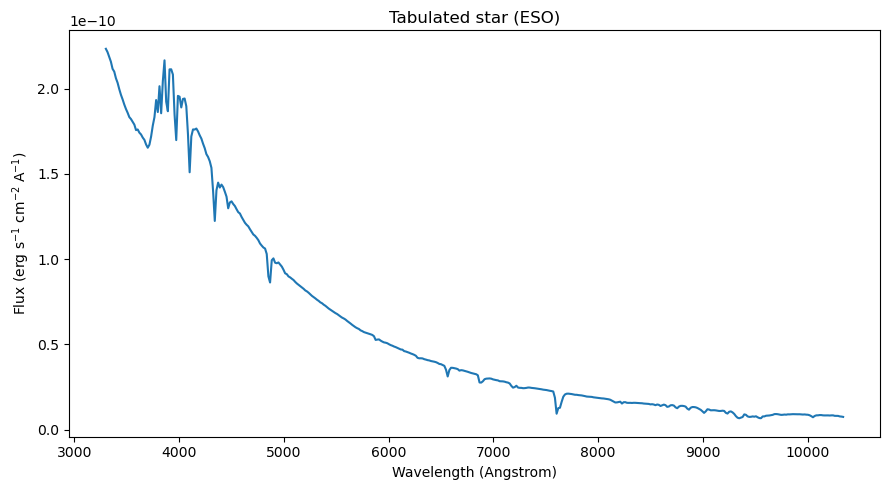

In [7]:
table_eso = ascii.read(dir_data / 'mhd3454.txt')
wave_eso = table_eso['col1']
magAB_eso = table_eso['col2']

# convert AB magnitudes to FLAM
flux_eso = 10**(-0.4*(magAB_eso+48.60))/(wave_eso**2) \
            * constants.c.cgs.value * 1E8

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(wave_eso,flux_eso)
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ A$^{-1}$)')
ax.set_title(f'Tabulated star (ESO)')
plt.tight_layout()

#### Telluric absorption

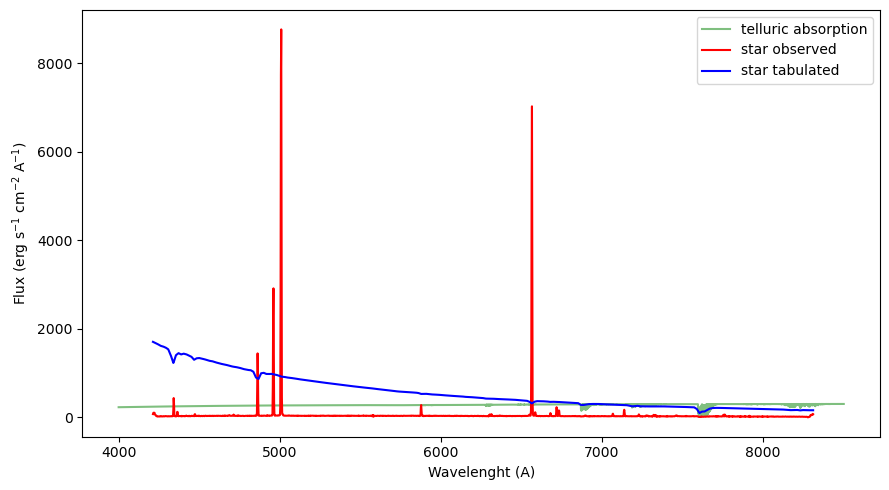

In [8]:
funinterp  = interp1d(wave_eso, flux_eso, kind='linear')
flux_model = funinterp(wave_obs)  # convert tabulated star in counts

telluric_tabulated = np.genfromtxt(dir_data / 'skycalc_transmission_R20000.txt')
xtelluric = telluric_tabulated[:,0] * 10  # convert from nm to Angstrom
ytelluric = telluric_tabulated[:,1]

iok = np.argwhere(np.logical_and(xtelluric >= 4000, xtelluric <= 8500))
xtelluric = xtelluric[iok]
ytelluric = ytelluric[iok]
ytelluric = ytelluric / ytelluric.max() * 300

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(xtelluric, ytelluric, label='telluric absorption', 
        color='green', alpha=0.5)
ax.plot(wave_obs, flux_obs, color='red', label='star observed')
ax.plot(wave_obs, flux_model*10**13, color='blue', label='star tabulated')
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ A$^{-1}$)')
ax.set_xlabel('Wavelenght (A)')
ax.legend()
plt.tight_layout()

### Response curve

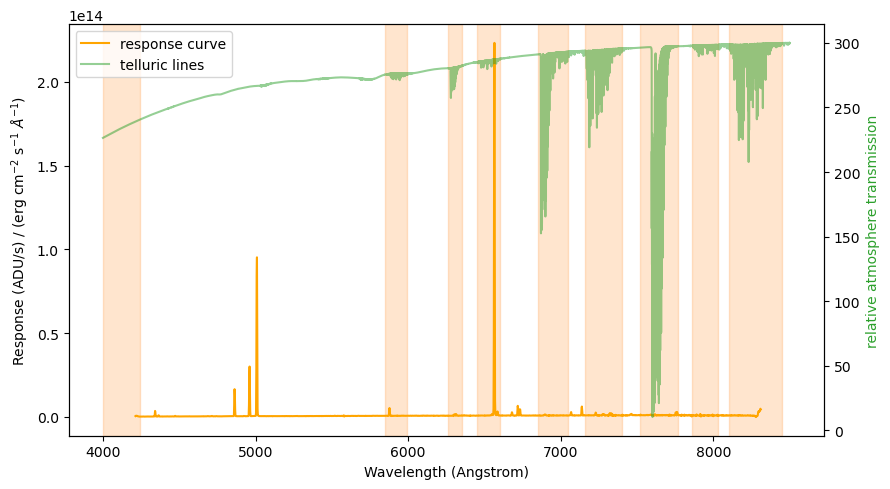

In [9]:
response = flux_obs / flux_model

# wavelength ranges
list_bad_regions = [
    (4000, 4240),
    (5850, 5990),
    (6260, 6350),
    (6450, 6600),
    (6850, 7050),
    (7160, 7400),
    (7520, 7770),
    (7860, 8030),
    (8100, 8450),
]

fig, ax1 = plt.subplots(figsize=(9, 5))
ax1.plot(wave_obs, response, label='response curve', color='orange')
ax1.set_xlabel('Wavelength (Angstrom)')
ax1.set_ylabel(r'Response (ADU/s) / (erg cm$^{−2}$ s$^{−1}$ $\AA^{−1}$)')

ax2 = ax1.twinx()
ax2.plot(xtelluric, ytelluric, color='C2', label='telluric lines', alpha=0.5)
ax2.set_ylabel('relative atmosphere transmission', color='C2')

ymin, ymax = ax1.get_ylim()
height = ymax - ymin
for w1, w2 in list_bad_regions:
    width = w2 - w1
    rect = patches.Rectangle(xy=(w1, ymin), width=width, height=height, 
                             color='C1', alpha=0.2)
    ax1.add_patch(rect)

# merge labels
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
for handle, label in zip(handles2, labels2):
    handles1.append(handle)
    labels1.append(label)
ax1.legend(handles1, labels1, loc='upper left')

plt.tight_layout()

The points in the spectrum corresponding to the problem regions are assigned a very small weight in the fit (weight_bad_region = 0.01; the weight of a normal point will be 1.0). Note that we keep those points in spite of everything so that the fit is calculated over the entire spectrum path in the spectral direction.


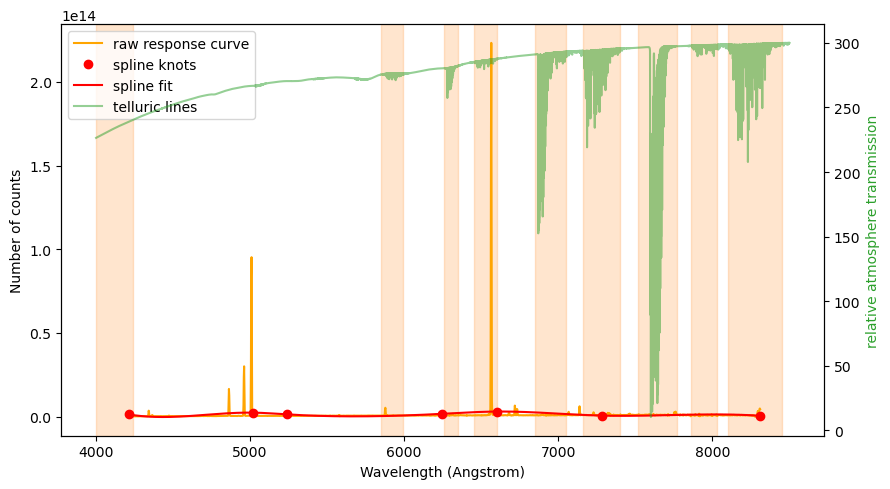

In [10]:
wave_obs[0] = wave_obs[1]
response[0] = response[1]

weight = np.ones((len(response)))

weight_bad_region = 0.005

for w1, w2 in list_bad_regions:
    i1 = (np.abs(wave_obs - w1)).argmin()
    i2 = (np.abs(wave_obs - w2)).argmin()
    weight[i1:(i2+1)] = weight_bad_region

number_of_intermediate_knots = 5
weight = np.ones((len(response)))

spl = AdaptiveLSQUnivariateSpline(x=wave_obs, y=response, w=weight, 
                                  t=number_of_intermediate_knots)

response_curve = spl(wave_obs)
xknots = spl.get_knots()
yknots = spl(xknots)

fig, ax1 = plt.subplots(figsize=(9, 5))
ax1.plot(wave_obs, response, label='raw response curve', color='orange')
ax1.plot(xknots, yknots, 'ro', label='spline knots')
ax1.plot(wave_obs, response_curve, 'r-', label='spline fit')
ax1.set_xlabel('Wavelength (Angstrom)')
ax1.set_ylabel('Number of counts')
#ax.set_ylim(0, 30000)
ax.legend()

ax2 = ax1.twinx()
ax2.plot(xtelluric, ytelluric, color='C2', label='telluric lines', alpha=0.5)
ax2.set_ylabel('relative atmosphere transmission', color='C2')

ymin, ymax = ax1.get_ylim()
height = ymax - ymin
for w1, w2 in list_bad_regions:
    width = w2 - w1
    rect = patches.Rectangle(xy=(w1, ymin), width=width, height=height, 
                             color='C1', alpha=0.2)
    ax1.add_patch(rect)

# merge labels
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
for handle, label in zip(handles2, labels2):
    handles1.append(handle)
    labels1.append(label)
ax1.legend(handles1, labels1)

plt.tight_layout()

In [11]:
## saving response curve
table_spectrum = QTable()

table_spectrum['wavelength'] = wave_obs*u.Angstrom
table_spectrum['response'] = response_curve

table_spectrum['wavelength'].info.format = '.2f'
table_spectrum['response'].info.format = '.2f'

table_spectrum.write(dir_calibration / 'response_curve.ecsv', overwrite=True)


### Flux calibration: spectro-photometric star

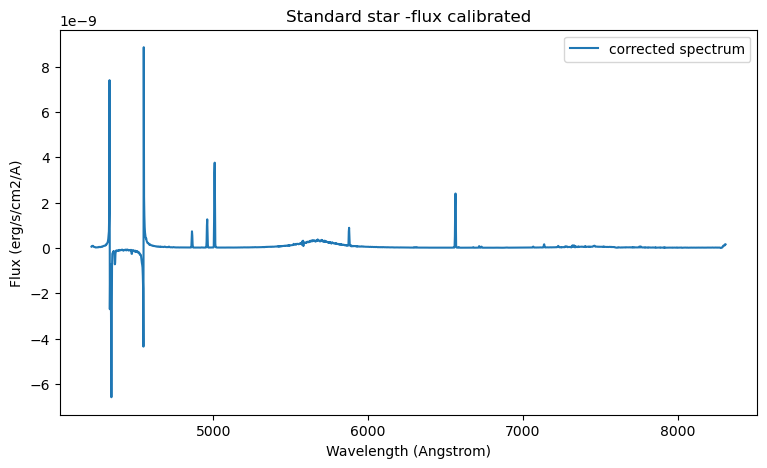

In [12]:
corrected_spectrum = flux_obs / response_curve

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(wave_obs, corrected_spectrum, label='corrected spectrum')
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Flux (erg/s/cm2/A)')
ax.set_title('Standard star -flux calibrated')
ax.legend()

### Flux calibration: galaxy

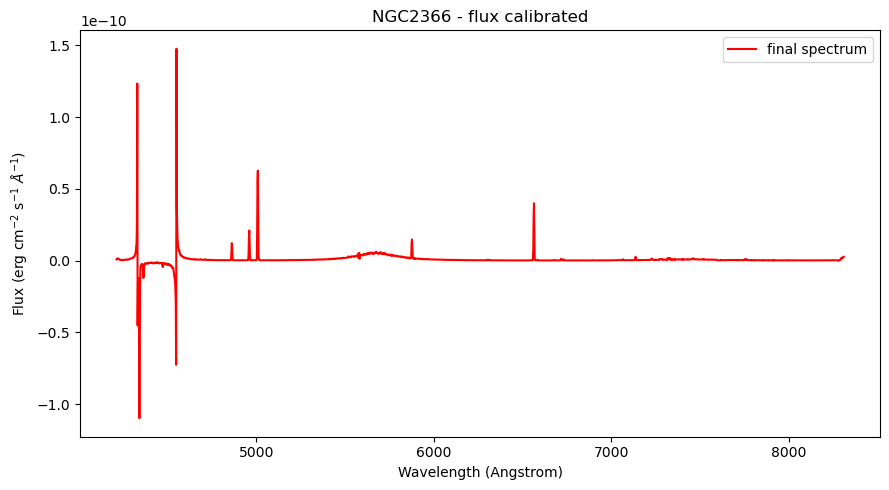

In [14]:
table_obs = np.genfromtxt(dir_calibration / f'NGC2366_1d_spec_atmcorr.ecsv')
wave_obs = table_obs[:, 0]
flux_obs = table_obs[:, 1]

header  = fits.getheader(dir_calibration / 't_science_galaxy_1.fits')
exptime = header['EXPTIME']

flux_obs = flux_obs /exptime

corrected_spectrum = flux_obs / response_curve

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(wave_obs, corrected_spectrum, color='red', label='final spectrum')
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel(r'Flux (erg cm$^{−2}$ s$^{−1}$ $\AA^{−1}$)')
ax.set_title(f'{galaxy_ID} - flux calibrated')
ax.legend()

plt.tight_layout()


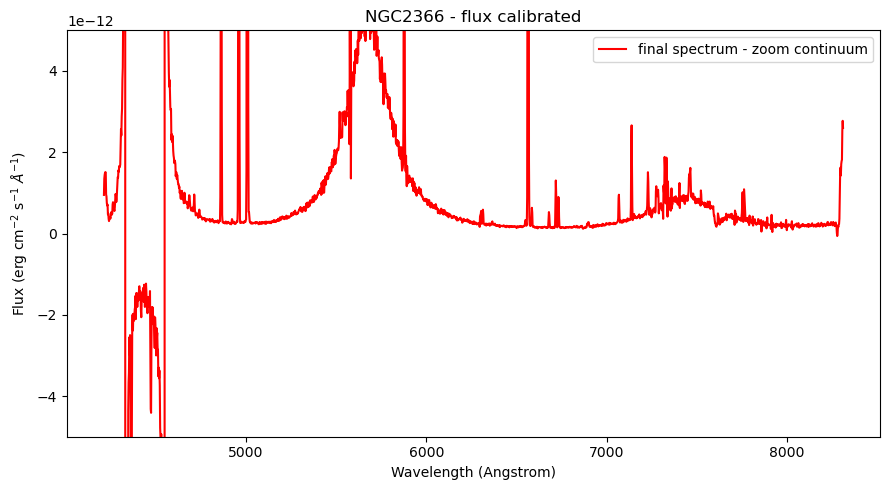

In [20]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(wave_obs, corrected_spectrum, color='red', label='final spectrum - zoom continuum')
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel(r'Flux (erg cm$^{−2}$ s$^{−1}$ $\AA^{−1}$)')
ax.set_title(f'{galaxy_ID} - flux calibrated')
ax.set_ylim(-0.5*1e-11,0.5*1e-11)
ax.legend()

plt.tight_layout()


In [16]:
## saving 1D spectrum
table_spectrum = QTable()

table_spectrum['wavelength'] = wave_obs*u.Angstrom
table_spectrum['flux'] = corrected_spectrum

table_spectrum['wavelength'].info.format = '.2f'
table_spectrum['flux'].info.format = '.2f'

table_spectrum.write(dir_calibration / f'{galaxy_ID}_1d_spec_calibrated.ecsv', overwrite=True)
